<a href="https://colab.research.google.com/github/oguzhankoc55/CNN/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.0
!pip install -U mxnet-cu101==1.7.0

     |████████████████████████████████| 83 kB 685 kB/s 
     |███████████████████████████████▌| 834.1 MB 1.2 MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x556162300000 @  0x7efdfd557615 0x5561293f34cc 0x5561294d347a 0x5561293f62ed 0x5561294e7e1d 0x556129469e99 0x5561294649ee 0x5561293f7bda 0x556129469d00 0x5561294649ee 0x5561293f7bda 0x556129466737 0x5561294e8c66 0x556129465daf 0x5561294e8c66 0x556129465daf 0x5561294e8c66 0x556129465daf 0x5561293f8039 0x55612943b409 0x5561293f6c52 0x556129469c25 0x5561294649ee 0x5561293f7bda 0x556129466737 0x5561294649ee 0x5561293f7bda 0x556129465915 0x5561293f7afa 0x556129465c0d 0x5561294649ee
     |████████████████████████████████| 846.0 MB 20 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

class Residual(nn.Block):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,
                               strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1,
                                   strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
        Y = npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return npx.relu(Y + X)

In [3]:
blk = Residual(3)
blk.initialize()
X = np.random.uniform(size=(4, 3, 6, 6))
blk(X).shape

(4, 3, 6, 6)

In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk.initialize()
blk(X).shape

(4, 6, 3, 3)

In [5]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3), nn.BatchNorm(),
        nn.Activation('relu'), nn.MaxPool2D(pool_size=3, strides=2,
                                            padding=1))

In [6]:
def resnet_block(num_channels, num_residuals, first_block=False):
    blk = nn.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

In [7]:
net.add(resnet_block(64, 2, first_block=True), resnet_block(128, 2),
        resnet_block(256, 2), resnet_block(512, 2))

In [8]:
net.add(nn.GlobalAvgPool2D(), nn.Dense(10))

In [9]:
X = np.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv5 output shape:	 (1, 64, 112, 112)
batchnorm4 output shape:	 (1, 64, 112, 112)
relu0 output shape:	 (1, 64, 112, 112)
pool0 output shape:	 (1, 64, 56, 56)
sequential1 output shape:	 (1, 64, 56, 56)
sequential2 output shape:	 (1, 128, 28, 28)
sequential3 output shape:	 (1, 256, 14, 14)
sequential4 output shape:	 (1, 512, 7, 7)
pool1 output shape:	 (1, 512, 1, 1)
dense0 output shape:	 (1, 10)


KeyboardInterrupt: ignored

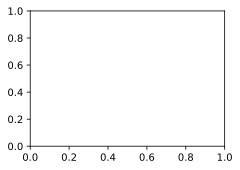

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())